In [1]:
import pandas as pd

df = pd.read_csv("C:\\PythonProjects\\PBL2\\cicids2017_cleaned.csv")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [2]:
df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [3]:
X = df.drop(['Attack Type'], axis=1)
y = df['Attack Type']

In [4]:
from sklearn.model_selection import train_test_split

# Perform a stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# Check class distribution
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Val class distribution:", Counter(y_val))

Training set size: 2016600
Validation set size: 504151
Train class distribution: Counter({'Normal Traffic': 1676045, 'DoS': 154996, 'DDoS': 102411, 'Port Scanning': 72555, 'Brute Force': 7320, 'Web Attacks': 1714, 'Bots': 1559})
Val class distribution: Counter({'Normal Traffic': 419012, 'DoS': 38749, 'DDoS': 25603, 'Port Scanning': 18139, 'Brute Force': 1830, 'Web Attacks': 429, 'Bots': 389})


In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

undersample = RandomUnderSampler(sampling_strategy={  
    'Normal Traffic': 1350000,  # Reduce, but keep enough  
    'DoS': 154996,  # Keep as is  
    'DDoS': 102411,  
    'Port Scanning': 72555,  
    'Brute Force': 7320,  
    'Web Attacks': 1714,  
    'Bots': 1559  
}, random_state=42) 

X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={  
    'Web Attacks': 15000, 
    'Bots': 15000,  
    'Brute Force': 30000  
}, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

In [6]:
print(pd.Series(y_train_resampled).value_counts())

Attack Type
Normal Traffic    1350000
DoS                154996
DDoS               102411
Port Scanning       72555
Brute Force         30000
Bots                15000
Web Attacks         15000
Name: count, dtype: int64


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels (string → integer)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)  # Train labels
y_val_encoded = label_encoder.transform(y_val)

In [9]:
import numpy as np

# Get unique class counts in train and validation sets
train_counts = np.bincount(y_train_encoded)
val_counts = np.bincount(y_val_encoded)

# Print label counts
print("Train Label Counts:")
for label, count in zip(np.unique(y_train_encoded), train_counts):
    print(f"  Class {label}: {count} samples")

print("\nValidation Label Counts:")
for label, count in zip(np.unique(y_val_encoded), val_counts):
    print(f"  Class {label}: {count} samples")

Train Label Counts:
  Class 0: 15000 samples
  Class 1: 30000 samples
  Class 2: 102411 samples
  Class 3: 154996 samples
  Class 4: 1350000 samples
  Class 5: 72555 samples
  Class 6: 15000 samples

Validation Label Counts:
  Class 0: 389 samples
  Class 1: 1830 samples
  Class 2: 25603 samples
  Class 3: 38749 samples
  Class 4: 419012 samples
  Class 5: 18139 samples
  Class 6: 429 samples


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert training data (balanced dataset)
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Convert validation data (original dataset)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Create DataLoaders
batch_size = 64 # <-- SET YOUR BATCH SIZE
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=4)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [40]:
import torch
import torch.nn as nn

class ReducedCNN_BiLSTM(nn.Module):
    def __init__(self, num_classes, input_size=52):
        super(ReducedCNN_BiLSTM, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropoutCNN2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=64, 
            hidden_size=32, 
            num_layers=1,  # Reduced from 2 to 1
            batch_first=True, 
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        # Fully Connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropoutCNN2(x)
        
        x = self.relu(self.bn3(self.conv3(x)))

        # Reshape for LSTM: [batch_size, seq_len, features]
        x = x.permute(0, 2, 1)

        # BiLSTM
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)

        # Attention
        # attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        # context = torch.sum(attn_weights * lstm_out, dim=1)

        # Classification
        # x = self.relu(self.fc1(context))
        x = self.fc2(x)

        return x


In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

num_classes = len(label_encoder.classes_)


# Define model, loss, optimizer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")

model = EnhancedCNN_BiLSTM(num_classes).to("cuda")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# LR Scheduler: Reduce LR if validation accuracy plateaus
total_steps = len(train_loader) * 30
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.005,   
    total_steps=total_steps,
    pct_start=0.3,  
    div_factor=25, 
    final_div_factor=1000
)

c:\PythonProjects\PBL2\pbl\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/15: 100%|██████████| 6797/6797 [00:57<00:00, 117.95it/s, loss=0.0976, acc=90.32%, lr=2.00e-04]
c:\PythonProjects\PBL2\pbl\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch [1/15] → Train Loss: 0.2640, Acc: 81.36% | Val Loss: 0.1071, Acc: 93.40% | LR: 2.00e-04
💾 New best model saved (93.40%)


Epoch 2/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.62it/s, loss=0.2311, acc=90.86%, lr=2.00e-04]



Epoch [2/15] → Train Loss: 0.1013, Acc: 92.60% | Val Loss: 0.0967, Acc: 93.59% | LR: 2.00e-04
💾 New best model saved (93.59%)


Epoch 3/15: 100%|██████████| 6797/6797 [00:57<00:00, 117.50it/s, loss=0.0425, acc=95.16%, lr=2.00e-04]



Epoch [3/15] → Train Loss: 0.0844, Acc: 93.73% | Val Loss: 0.0896, Acc: 93.74% | LR: 2.00e-04
💾 New best model saved (93.74%)


Epoch 4/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.71it/s, loss=0.0269, acc=95.70%, lr=2.00e-04]



Epoch [4/15] → Train Loss: 0.0769, Acc: 94.20% | Val Loss: 0.0602, Acc: 96.48% | LR: 2.00e-04
💾 New best model saved (96.48%)


Epoch 5/15: 100%|██████████| 6797/6797 [00:56<00:00, 120.98it/s, loss=0.0546, acc=94.62%, lr=2.00e-04]



Epoch [5/15] → Train Loss: 0.0682, Acc: 95.01% | Val Loss: 0.0596, Acc: 95.32% | LR: 2.00e-04


Epoch 6/15: 100%|██████████| 6797/6797 [00:57<00:00, 117.67it/s, loss=0.1668, acc=93.55%, lr=2.00e-04]



Epoch [6/15] → Train Loss: 0.0632, Acc: 95.42% | Val Loss: 0.0503, Acc: 96.33% | LR: 2.00e-04


Epoch 7/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.32it/s, loss=0.0453, acc=94.62%, lr=2.00e-04]



Epoch [7/15] → Train Loss: 0.0591, Acc: 95.70% | Val Loss: 0.0504, Acc: 95.92% | LR: 2.00e-04


Epoch 8/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.01it/s, loss=0.0381, acc=96.24%, lr=2.00e-04] 



Epoch [8/15] → Train Loss: 0.0554, Acc: 95.77% | Val Loss: 0.0449, Acc: 96.72% | LR: 2.00e-04
💾 New best model saved (96.72%)


Epoch 9/15: 100%|██████████| 6797/6797 [00:56<00:00, 119.84it/s, loss=0.0299, acc=98.92%, lr=2.00e-04] 



Epoch [9/15] → Train Loss: 0.0536, Acc: 96.00% | Val Loss: 0.0438, Acc: 96.77% | LR: 2.00e-04
💾 New best model saved (96.77%)


Epoch 10/15: 100%|██████████| 6797/6797 [00:57<00:00, 117.91it/s, loss=0.0512, acc=93.01%, lr=2.00e-04]



Epoch [10/15] → Train Loss: 0.0518, Acc: 96.07% | Val Loss: 0.0560, Acc: 95.66% | LR: 2.00e-04


Epoch 11/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.40it/s, loss=0.0602, acc=93.01%, lr=2.00e-04] 



Epoch [11/15] → Train Loss: 0.0506, Acc: 96.23% | Val Loss: 0.0434, Acc: 96.74% | LR: 2.00e-04


Epoch 12/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.15it/s, loss=0.0375, acc=94.62%, lr=2.00e-04]



Epoch [12/15] → Train Loss: 0.0486, Acc: 96.32% | Val Loss: 0.0419, Acc: 96.76% | LR: 2.00e-04


Epoch 13/15: 100%|██████████| 6797/6797 [00:57<00:00, 117.35it/s, loss=0.0307, acc=96.24%, lr=2.00e-04]



Epoch [13/15] → Train Loss: 0.0485, Acc: 96.41% | Val Loss: 0.0444, Acc: 96.40% | LR: 2.00e-04


Epoch 14/15: 100%|██████████| 6797/6797 [00:57<00:00, 118.60it/s, loss=0.0173, acc=96.24%, lr=2.00e-04]



Epoch [14/15] → Train Loss: 0.0476, Acc: 96.51% | Val Loss: 0.0442, Acc: 96.85% | LR: 2.00e-04
💾 New best model saved (96.85%)


Epoch 15/15: 100%|██████████| 6797/6797 [01:00<00:00, 112.93it/s, loss=0.0326, acc=96.77%, lr=2.00e-04] 



Epoch [15/15] → Train Loss: 0.0466, Acc: 96.57% | Val Loss: 0.0406, Acc: 97.02% | LR: 2.00e-04
💾 New best model saved (97.02%)

🏆 Best Validation Accuracy: 97.02%


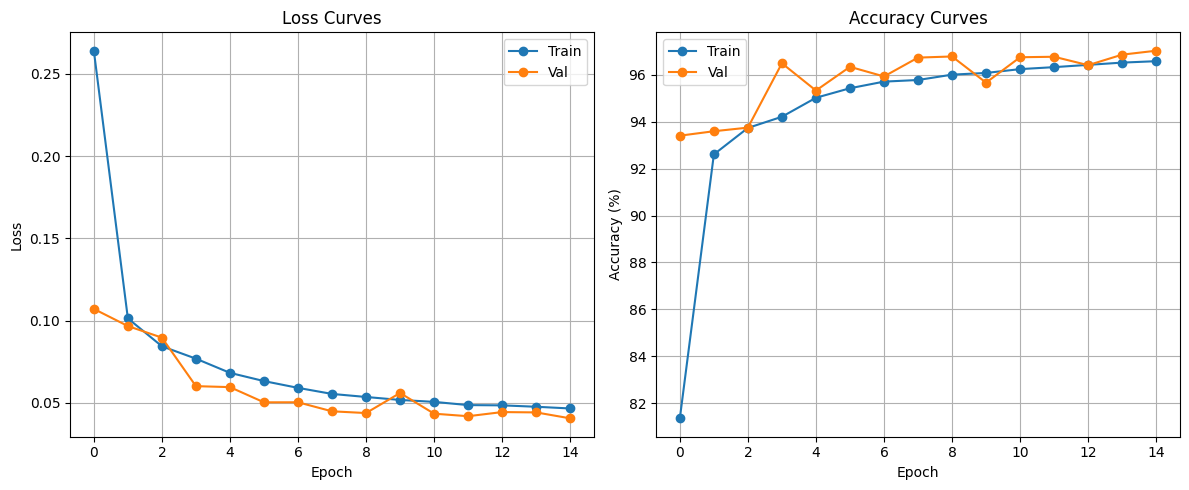

In [42]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epochs = 15
patience = 15
min_delta = 0.001  # Minimum accuracy improvement to consider
max_grad_norm = 1.0  # Gradient clipping threshold

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    # Training Phase
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        batch_acc = (predicted == y_batch).sum().item()/y_batch.size(0)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

        # Enhanced progress bar
        loop.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{batch_acc:.2%}",
            'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
        })

    # Calculate epoch metrics
    train_acc = train_correct / train_total * 100
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = val_correct / val_total * 100
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.2e}")

    # Save best model
    if val_acc > best_val_acc + min_delta:
        torch.save(model.state_dict(), "nids_v9_best.pth")
        print(f"💾 New best model saved ({val_acc:.2f}%)")
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
        break

# Final Report
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses, label="Val", marker="o")
plt.title("Loss Curves"), plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train", marker="o")
plt.plot(val_accuracies, label="Val", marker="o")
plt.title("Accuracy Curves"), plt.xlabel("Epoch"), plt.ylabel("Accuracy (%)"), plt.legend(), plt.grid()

plt.tight_layout()
plt.show()


Epoch 16/30:   0%|          | 0/6797 [00:00<?, ?it/s]

Epoch 16/30: 100%|██████████| 6797/6797 [01:02<00:00, 108.23it/s, loss=0.0219, acc=96.24%, lr=2.00e-04]
c:\PythonProjects\PBL2\pbl\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch [16/30] → Train Loss: 0.0456, Acc: 96.64% | Val Loss: 0.0419, Acc: 96.72% | LR: 2.00e-04


Epoch 17/30: 100%|██████████| 6797/6797 [01:00<00:00, 113.27it/s, loss=0.0306, acc=97.31%, lr=2.00e-04] 



Epoch [17/30] → Train Loss: 0.0443, Acc: 96.72% | Val Loss: 0.0391, Acc: 97.03% | LR: 2.00e-04
💾 New best model saved (97.03%)


Epoch 18/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.41it/s, loss=0.0885, acc=95.70%, lr=2.00e-04] 



Epoch [18/30] → Train Loss: 0.0434, Acc: 96.85% | Val Loss: 0.0355, Acc: 97.46% | LR: 2.00e-04
💾 New best model saved (97.46%)


Epoch 19/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.83it/s, loss=0.0259, acc=95.70%, lr=2.00e-04] 



Epoch [19/30] → Train Loss: 0.0421, Acc: 96.91% | Val Loss: 0.0401, Acc: 96.77% | LR: 2.00e-04


Epoch 20/30: 100%|██████████| 6797/6797 [00:58<00:00, 116.26it/s, loss=0.0132, acc=99.46%, lr=2.00e-04] 



Epoch [20/30] → Train Loss: 0.0403, Acc: 96.94% | Val Loss: 0.0337, Acc: 97.29% | LR: 2.00e-04


Epoch 21/30: 100%|██████████| 6797/6797 [01:02<00:00, 108.36it/s, loss=0.0167, acc=97.31%, lr=2.00e-04] 



Epoch [21/30] → Train Loss: 0.0386, Acc: 97.07% | Val Loss: 0.0404, Acc: 97.08% | LR: 2.00e-04


Epoch 22/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.51it/s, loss=0.0069, acc=98.92%, lr=2.00e-04] 



Epoch [22/30] → Train Loss: 0.0386, Acc: 97.09% | Val Loss: 0.0334, Acc: 97.49% | LR: 2.00e-04
💾 New best model saved (97.49%)


Epoch 23/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.35it/s, loss=0.0077, acc=97.85%, lr=2.00e-04] 



Epoch [23/30] → Train Loss: 0.0382, Acc: 97.11% | Val Loss: 0.0337, Acc: 97.58% | LR: 2.00e-04
💾 New best model saved (97.58%)


Epoch 24/30: 100%|██████████| 6797/6797 [00:59<00:00, 113.91it/s, loss=0.0196, acc=96.24%, lr=2.00e-04] 



Epoch [24/30] → Train Loss: 0.0374, Acc: 97.20% | Val Loss: 0.0357, Acc: 97.18% | LR: 2.00e-04


Epoch 25/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.26it/s, loss=0.0271, acc=97.31%, lr=2.00e-04] 



Epoch [25/30] → Train Loss: 0.0363, Acc: 97.34% | Val Loss: 0.0382, Acc: 97.08% | LR: 2.00e-04


Epoch 26/30: 100%|██████████| 6797/6797 [00:59<00:00, 113.76it/s, loss=0.0188, acc=97.85%, lr=2.00e-04] 



Epoch [26/30] → Train Loss: 0.0364, Acc: 97.30% | Val Loss: 0.0326, Acc: 97.45% | LR: 2.00e-04


Epoch 27/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.90it/s, loss=0.0375, acc=97.31%, lr=2.00e-04] 



Epoch [27/30] → Train Loss: 0.0355, Acc: 97.37% | Val Loss: 0.0316, Acc: 97.72% | LR: 2.00e-04
💾 New best model saved (97.72%)


Epoch 28/30: 100%|██████████| 6797/6797 [00:58<00:00, 115.52it/s, loss=0.0309, acc=96.24%, lr=2.00e-04] 



Epoch [28/30] → Train Loss: 0.0345, Acc: 97.43% | Val Loss: 0.0365, Acc: 97.16% | LR: 2.00e-04


Epoch 29/30: 100%|██████████| 6797/6797 [00:59<00:00, 114.65it/s, loss=0.0061, acc=98.39%, lr=2.00e-04] 



Epoch [29/30] → Train Loss: 0.0349, Acc: 97.38% | Val Loss: 0.0315, Acc: 97.66% | LR: 2.00e-04


Epoch 30/30: 100%|██████████| 6797/6797 [00:59<00:00, 115.05it/s, loss=0.0872, acc=95.70%, lr=2.00e-04] 



Epoch [30/30] → Train Loss: 0.0350, Acc: 97.45% | Val Loss: 0.0319, Acc: 97.71% | LR: 2.00e-04

🏆 Best Validation Accuracy: 97.72%


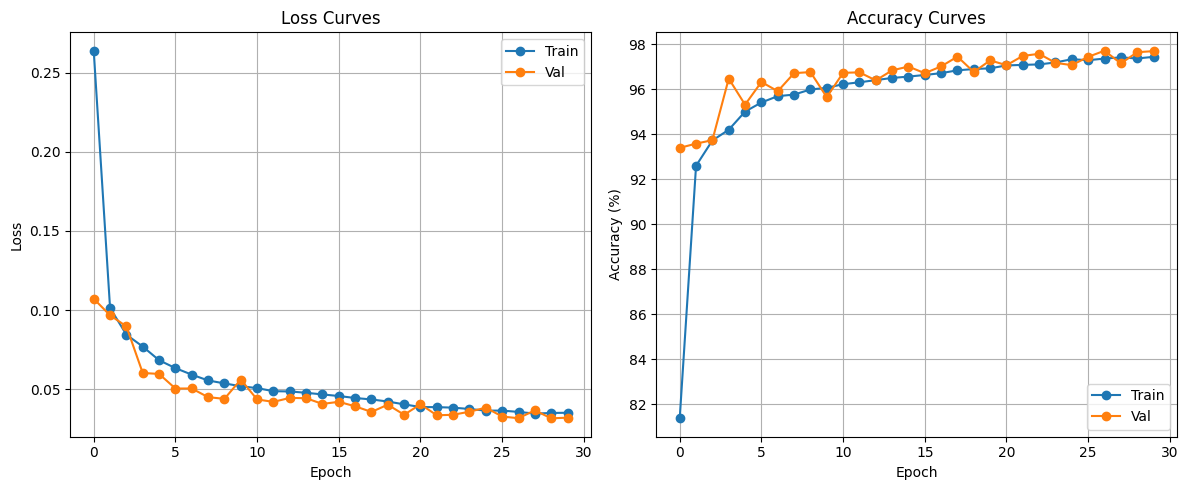

In [49]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

best_val_acc = 97.02
epochs_no_improve = 0
num_epochs = 30
patience = 15
min_delta = 0.001  # Minimum accuracy improvement to consider
max_grad_norm = 1.0  # Gradient clipping threshold

# --- Training Loop ---
for epoch in range(15, num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    # Training Phase
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        batch_acc = (predicted == y_batch).sum().item()/y_batch.size(0)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

        # Enhanced progress bar
        loop.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{batch_acc:.2%}",
            'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
        })

    # Calculate epoch metrics
    train_acc = train_correct / train_total * 100
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = val_correct / val_total * 100
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.2e}")

    # Save best model
    if val_acc > best_val_acc + min_delta:
        torch.save(model.state_dict(), "nids_v9_best.pth")
        print(f"💾 New best model saved ({val_acc:.2f}%)")
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
        break

# Final Report
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses, label="Val", marker="o")
plt.title("Loss Curves"), plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train", marker="o")
plt.plot(val_accuracies, label="Val", marker="o")
plt.title("Accuracy Curves"), plt.xlabel("Epoch"), plt.ylabel("Accuracy (%)"), plt.legend(), plt.grid()

plt.tight_layout()
plt.show()


In [50]:
torch.save(model, "nids_v9.pth")

In [51]:
import numpy as np

y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        outputs = model(X_batch)  # Raw model outputs
        probs = torch.softmax(outputs, dim=1)  # Convert to probabilities

        y_true.extend(y_batch.cpu().numpy())  # True labels
        y_scores.extend(probs.cpu().numpy())  # Probabilities for each class


['Bots' 'Brute Force' 'DDoS' 'DoS' 'Normal Traffic' 'Port Scanning'
 'Web Attacks']


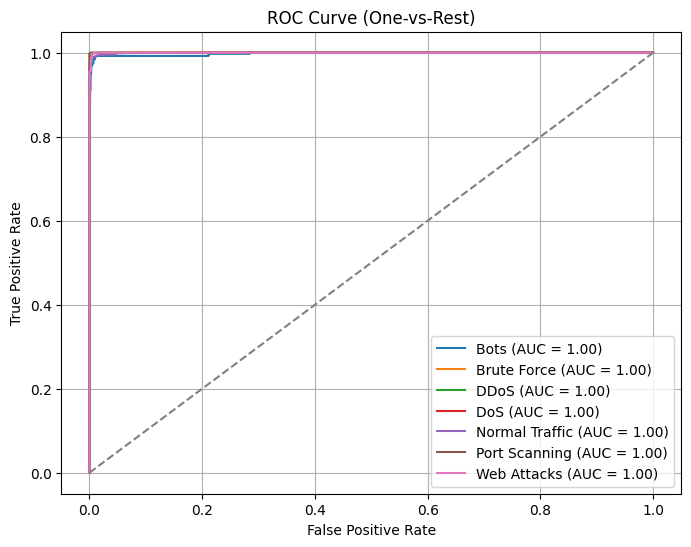

In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class (One-vs-Rest)
n_classes = len(set(y_true))  # Number of classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # Convert to binary format

class_names = label_encoder.classes_
print(class_names)

# Compute ROC Curve & AUC for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


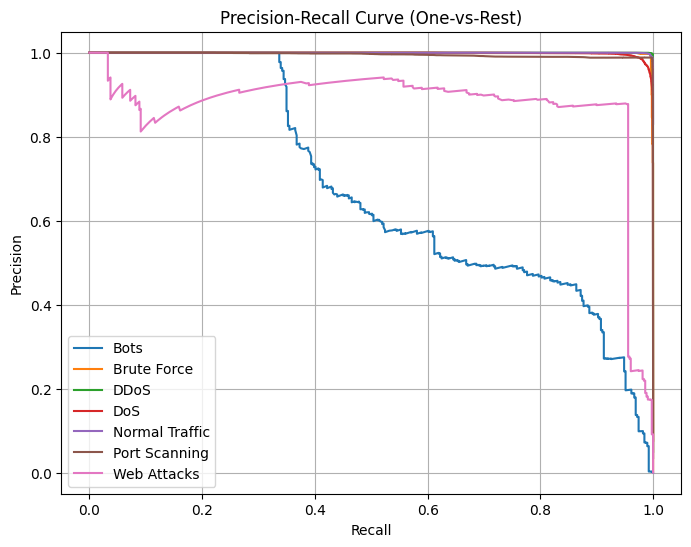

In [53]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


In [54]:
torch.save(model.state_dict(), "nids_v9_modelState.pth")